In [2]:
""""
Figaro times collection times script. 
"""
import numpy as np
import pandas as pd
import os
from openpyxl import load_workbook, Workbook
from openpyxl.utils.cell import get_column_letter

perf_path_init = r"/local/scratch/Figaro/figaro-code"
exp_names = ["figaro", "mkl"]
exp_paths = {"figaro": r"comparisons/performance/figaro", "mkl": r"comparisons/performance/python/numpy"}
db_names = ["DBRetailer", "DBFavorita", "DBYelp"]
thread_nums_exp = {"mkl": [48], "figaro": [1, 2, 4, 8, 16, 24, 32, 48]}

join_orders = {"DBFavorita": ["HolidaysRoot", "ItemsRoot", "OilRoot", "SalesRoot", "StoresRoot"],
              "DBYelp": ["BusinessRoot", "CategoryRoot", "CheckinRoot", "HoursRoot", "ReviewRoot", "UserRoot"], 
              "DBRetailer": ["CensusRoot", "InventoryRoot", "ItemRoot", "LocationRoot"]}

start_per = 10
end_per = 100
per_inc = 10

num_measurement = 5

xlsx_name = "time.xlsx"

df_measurement_exp_dbs = {}
for exp_name in exp_names: 
    exp_path = exp_paths[exp_name]
    perf_path = os.path.join(perf_path_init, exp_path)

    for db_name in db_names:
        gather_times_path = os.path.join(perf_path, db_name + xlsx_name)
        print(gather_times_path)
        out_workbook = Workbook()
        out_workbook.remove(out_workbook.active)
        out_sheet = out_workbook.create_sheet("Times")
        df_measurement = pd.DataFrame(columns=join_orders[db_name])
        
        for join_idx, join_order in enumerate(join_orders[db_name]):
            for thread_idx, thread_num in enumerate(thread_nums_exp[exp_name]):
                for db_idx, percent in enumerate(range(start_per, end_per + 1, per_inc)): 
                    db_name_full = "{} {} {}".format(db_name, join_order, thread_num)
                    path_xlsx = os.path.join(perf_path, db_name, join_order+str(thread_num), xlsx_name)
                    print("PATH", path_xlsx)
                    workbook = load_workbook(filename=path_xlsx, data_only=True)
                    sheet = workbook.active
                    row_count = sheet.max_row
                    col_idx = join_idx * thread_nums_exp[exp_name].__len__() + thread_idx + 1
                    col_letter = get_column_letter(col_idx)
                    
                    out_sheet.cell(row=1, column=col_idx).value = db_name_full
                    
                    start_row_idx = 2
                    np_measures = np.zeros(num_measurement)
                    for row_idx_dst in range(start_row_idx, start_row_idx + num_measurement):
                        offset_idx = row_idx_dst - start_row_idx
                        row_idx_src = row_count - num_measurement  + offset_idx
                        val = sheet.cell(row=row_idx_src, column=2).value
                        np_measures[offset_idx] = float(val)
                        #print(idx_shift, db_idx)
                        out_sheet.cell(row=row_idx_dst, column=col_idx).value = val
                    
                    out_sheet.cell(row=start_row_idx + num_measurement, column=col_idx).value = '=AVERAGE({}{}:{}{})'.format(col_letter, start_row_idx + 1, 
                            col_letter,6)

                    time_avg = np.mean(np_measures[1:])
                    df_measurement.at[thread_num, join_order] = time_avg
                
        out_workbook.save(gather_times_path)
        df_measurement_exp_dbs[(exp_name, db_name)] = df_measurement





/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailertime.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot1/time.xlsx
PATH /local/scratch/Figaro/figaro-code/comparisons/performance/figaro/DBRetailer/CensusRoot

   CensusRoot InventoryRoot ItemRoot LocationRoot
1     74.9489       243.817  196.259      74.9234
2     46.1165       164.802  126.946      47.0742
4     26.1864       93.3111  77.2049      25.9618
8     15.6485       68.6454  44.7371      15.4112
16    11.1688       60.2955  34.0205      11.0341
24    9.78209       67.7705  32.0513      9.80228
32    9.89192        69.053  28.3705      10.4932
48    9.68755       65.0998  26.4004       9.1209
   HolidaysRoot ItemsRoot  OilRoot SalesRoot StoresRoot
1       200.561   213.375  52.1254   235.111    51.7529
2       121.024   127.321  40.2224   155.174    38.5316
4       67.0885   71.6995  22.5906   95.3761     25.568
8       46.5648   45.2659  15.5046   71.6972    13.9813
16      37.2789   34.5798  9.42484   64.6371     9.5281
24      31.2913   30.9373  7.48096   61.7455    7.35561
32      30.9444   33.0724  6.96212   59.7387    7.25151
48      30.7279    31.078  5.93527   60.0595    5.82257
   BusinessRoot CategoryRoot CheckinRoot Hours

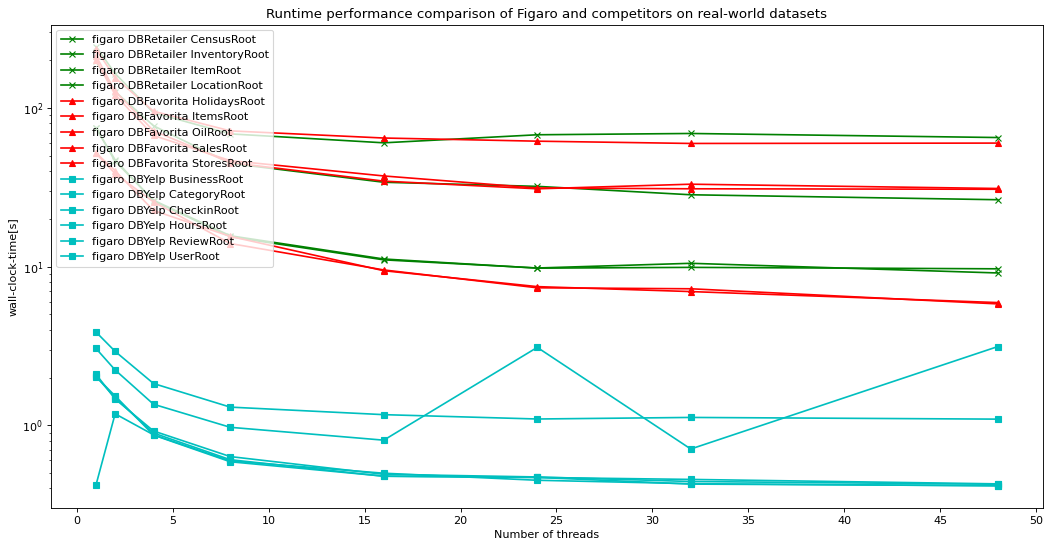

In [3]:
import matplotlib.pyplot as plt

plt.figure("name", figsize=(16, 8), dpi=80)
plt.xlabel("Number of threads")
plt.ylabel("wall-clock-time[s]")

plt.title("Runtime performance comparison of Figaro and competitors on real-world datasets")

plt.yscale('log', base=10)
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='x', nbins=20)
db_marker =  {"DBFavorita": "^", "DBYelp": "s", "DBRetailer": "x"}
db_colour =  {"DBFavorita": "r", "DBYelp": "c", "DBRetailer": "g"}
exp_colour = {"figaro": "r", "mkl": "b"}

for exp_name in exp_names:
    if exp_name == "mkl":
        continue
    for db_name in db_names:
        df_measurement = df_measurement_exp_dbs[(exp_name, db_name)]
        print(df_measurement)
        for join_order in join_orders[db_name]:
            plt.plot(df_measurement[join_order], "-" + db_colour[db_name] + db_marker[db_name], label="{} {} {}".format(exp_name, db_name, join_order))
plt.legend(loc="upper left")

plt.show()